In [1]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

# 視覺化資料

In [2]:
target_labels = ['None', 'Mild', 'Moderate', 'Severe']

In [3]:
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

train = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

test = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

train
test

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,enum,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,null,null,null,"""Fall""",3
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",46,64,"""Summer""",0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",38,54,"""Summer""",2
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",31,45,"""Winter""",0
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""00c0cd71""","""Winter""",7,0,"""Summer""",51,"""Spring""",29.315775,54.0,121.6,null,80,75,99,"""Spring""",4,5,32,"""Spring""",6,1,null,null,null,null,0,0,12.0,1,15.0,1,12.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Spring""",35,50,"""Winter""",2
"""00d56d4b""","""Spring""",5,1,"""Summer""",80,"""Spring""",17.284504,44.0,47.6,null,61,76,109,"""Spring""",null,null,null,"""Spring""",0,0,null,null,null,null,0,0,10.5,1,10.0,1,7.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Spring""",37,53,"""Spring""",0
"""00d9913d""","""Fall""",10,1,null,null,"""Fall""",19.893157,55.0,85.6,30.0,null,81,null,null,null,null,null,"""Fall""",5,0,null,null,null,null,0,0,0.0,0,0.0,0,9.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Fall""",1


In [4]:
train

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,…,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,enum,i64,i64,enum,i64,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ff8a2de4""","""Fall""",13,0,"""Spring""",60,"""Fall""",16.36246,59.5,82.4,null,71,70,104,null,null,null,null,"""Fall""",16,0,18.0,1,19.9,2,10,1,8.0,1,9.0,1,12.0,1,"""Fall""",3,4.52277,16.3642,…,33.3709,17.9797,66.2889,29.779,52.832,null,null,"""Winter""",3.26,"""Winter""",3,3,3,2,3,2,2,2,2,1,2,0,2,0,1,0,2,1,1,0,32,"""Winter""",35,50,"""Fall""",1,1
"""ffa9794a""","""Winter""",10,0,null,null,"""Spring""",18.764678,53.5,76.4,27.0,60,78,118,null,null,null,null,"""Spring""",0,0,null,null,null,null,4,0,0.0,0,0.0,0,12.0,1,"""Spring""",null,null,null,…,null,nu

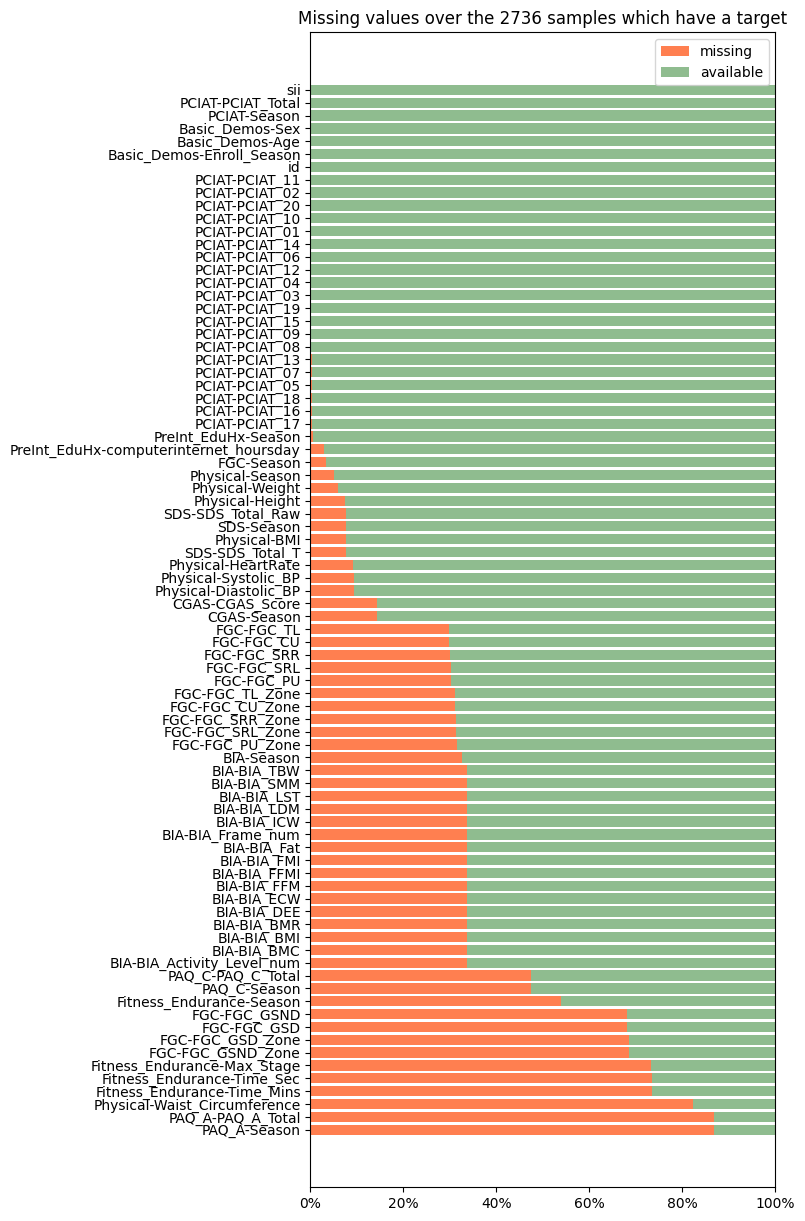

In [5]:
supervised_usable = (
    train
    .filter(pl.col('sii').is_not_null())
)

missing_count = (
    supervised_usable
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(supervised_usable)).alias('null_ratio'))
)
plt.figure(figsize=(6, 15))
plt.title(f'Missing values over the {len(supervised_usable)} samples which have a target')
plt.barh(np.arange(len(missing_count)), missing_count.get_column('null_ratio'), color='coral', label='missing')
plt.barh(np.arange(len(missing_count)), 
         1 - missing_count.get_column('null_ratio'),
         left=missing_count.get_column('null_ratio'),
         color='darkseagreen', label='available')
plt.yticks(np.arange(len(missing_count)), missing_count.get_column('feature'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

In [6]:
missing_count

feature,null_count,null_ratio
str,u32,f64
"""PAQ_A-Season""",2373,0.867325
"""PAQ_A-PAQ_A_Total""",2373,0.867325
"""Physical-Waist_Circumference""",2253,0.823465
"""Fitness_Endurance-Time_Mins""",2008,0.733918
"""Fitness_Endurance-Time_Sec""",2008,0.733918
…,…,…
"""Basic_Demos-Age""",0,0.0
"""Basic_Demos-Sex""",0,0.0
"""PCIAT-Season""",0,0.0


In [7]:
print(train.select(pl.col('PCIAT-PCIAT_Total').is_null() == pl.col('sii').is_null()).to_series().mean())

(train
 .select(pl.col('PCIAT-PCIAT_Total'))
 .group_by(train.get_column('sii'))
 .agg(pl.col('PCIAT-PCIAT_Total').min().alias('PCIAT-PCIAT_Total min'),
      pl.col('PCIAT-PCIAT_Total').max().alias('PCIAT-PCIAT_Total max'),
      pl.col('PCIAT-PCIAT_Total').len().alias('count'))
 .sort('sii')
)

1.0


sii,PCIAT-PCIAT_Total min,PCIAT-PCIAT_Total max,count
i64,i64,i64,u32
null,null,null,1224
0,0,30,1594
1,31,49,730
2,50,79,378
3,80,93,34


In [8]:
print('Columns missing in test:')
print([f for f in train.columns if f not in test.columns])

Columns missing in test:
['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


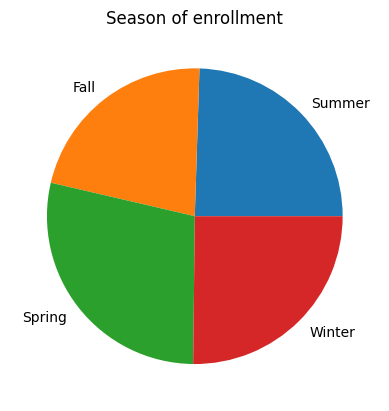

In [9]:
vc = train.get_column('Basic_Demos-Enroll_Season').value_counts()
plt.pie(vc.get_column('count'), labels=vc.get_column('Basic_Demos-Enroll_Season'))
plt.title('Season of enrollment')
plt.show()

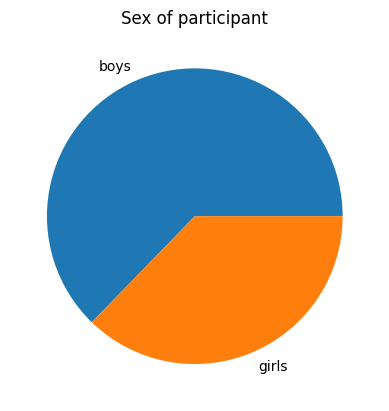

In [10]:
vc = train.get_column('Basic_Demos-Sex').value_counts()
plt.pie(vc.get_column('count'), labels=['boys', 'girls'])
plt.title('Sex of participant')
plt.show()

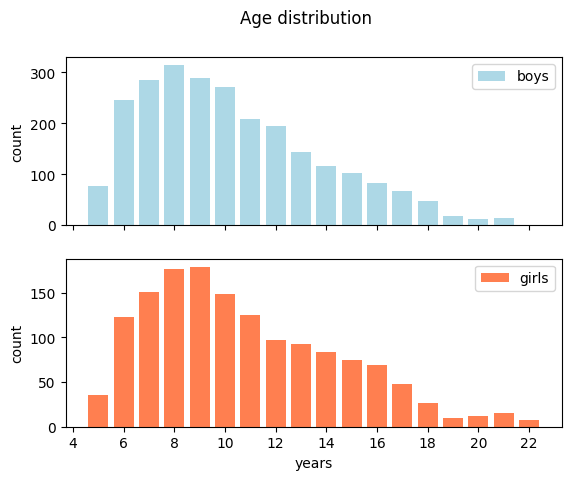

In [11]:
_, axs = plt.subplots(2, 1, sharex=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('Basic_Demos-Age').value_counts()
    ax.bar(vc.get_column('Basic_Demos-Age'),
           vc.get_column('count'),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Age distribution')
axs.ravel()[1].set_xlabel('years')
plt.show()

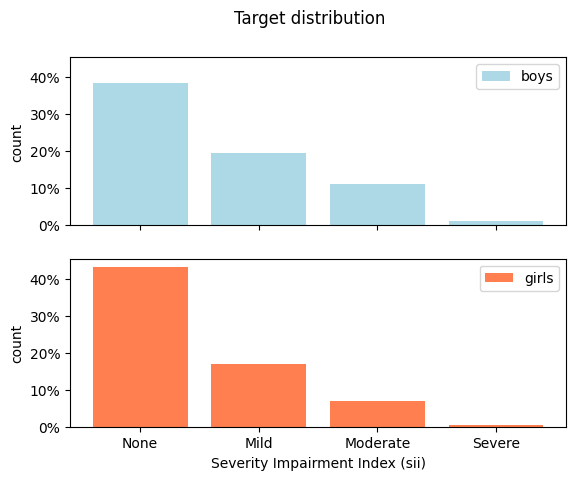

In [12]:
_, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('sii').value_counts()
    ax.bar(vc.get_column('sii'),
           vc.get_column('count') / vc.get_column('count').sum(),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.set_xticks(np.arange(4), target_labels)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Target distribution')
axs.ravel()[1].set_xlabel('Severity Impairment Index (sii)')
plt.show()

Basic_Demos-Age                           0.409559
Physical-BMI                              0.240858
Physical-Height                           0.420765
Physical-Weight                           0.353048
Physical-Waist_Circumference              0.327013
Physical-Systolic_BP                      0.147081
PreInt_EduHx-computerinternet_hoursday    0.374124
SDS-SDS_Total_T                           0.237718
FGC-FGC_CU                                0.287494
FGC-FGC_GSND                              0.146813
FGC-FGC_GSD                               0.160472
FGC-FGC_PU                                0.196006
FGC-FGC_TL                                0.136696
BIA-BIA_BMI                               0.248060
BIA-BIA_FFMI                              0.109694
BIA-BIA_Frame_num                         0.193631
Name: PCIAT-PCIAT_Total, dtype: float64


<Figure size 1400x1200 with 0 Axes>

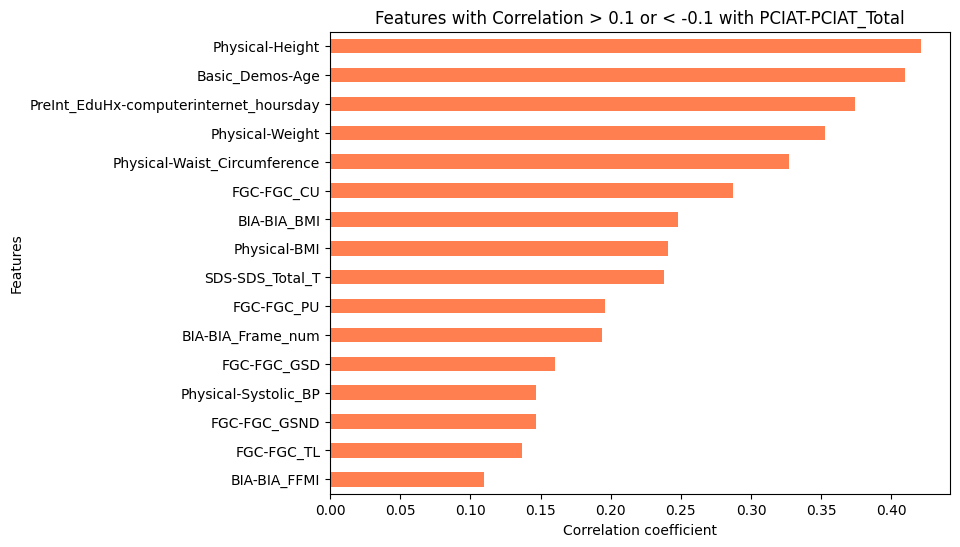

In [13]:
plt.figure(figsize=(14, 12))
corr_matrix = supervised_usable.select([
    'PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 
    'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Physical-HeartRate',
    'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec',
    'FGC-FGC_CU', 'FGC-FGC_GSND','FGC-FGC_GSD','FGC-FGC_PU','FGC-FGC_SRL','FGC-FGC_SRR','FGC-FGC_TL','BIA-BIA_Activity_Level_num', 
    'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
    'BIA-BIA_FFMI','BIA-BIA_FMI', 'BIA-BIA_Fat','BIA-BIA_Frame_num','BIA-BIA_ICW','BIA-BIA_LDM','BIA-BIA_LST',
    'BIA-BIA_SMM','BIA-BIA_TBW'
    # Add other relevant columns
]).to_pandas().corr()

sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')
filtered_corr = sii_corr[(sii_corr > 0.1) | (sii_corr < -0.1)]

print(filtered_corr)

plt.figure(figsize=(8, 6))
filtered_corr.sort_values().plot(kind='barh', color='coral')
plt.title('Features with Correlation > 0.1 or < -0.1 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()

In [14]:
actigraphy = pl.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet')
actigraphy

step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
u32,f32,f32,f32,f32,f32,f32,f32,f32,i64,i8,i8,f32
0,0.014375,-0.020112,-0.995358,0.00106,-88.445251,0.0,41.0,4195.0,44100000000000,2,2,5.0
1,0.014167,-0.023278,-0.996164,0.000289,-88.3722,0.0,41.0,4194.833496,44105000000000,2,2,5.0
2,0.014036,-0.022964,-0.99632,0.000301,-88.356422,0.0,41.5,4194.666504,44110000000000,2,2,5.0
3,0.013593,-0.022048,-0.996762,0.002278,-88.575943,0.0,37.5,4194.5,44115000000000,2,2,5.0
4,-0.061772,-0.065317,-0.973063,0.092321,-88.391273,0.0,55.666668,4199.0,44780000000000,2,2,5.0
…,…,…,…,…,…,…,…,…,…,…,…,…
287174,-0.407433,0.091612,-0.377763,0.039733,-43.319416,0.0,7.0,3695.0,32875000000000,1,3,53.0
287175,-0.703572,0.016187,0.15956,0.03598,14.12139,0.0,7.0,3695.0,32880000000000,1,3,53.0
287176,-0.209607,-0.4697,0.636573,0.097799,44.998573,0.0,7.0,3695.0,32885000000000,1,3,53.0


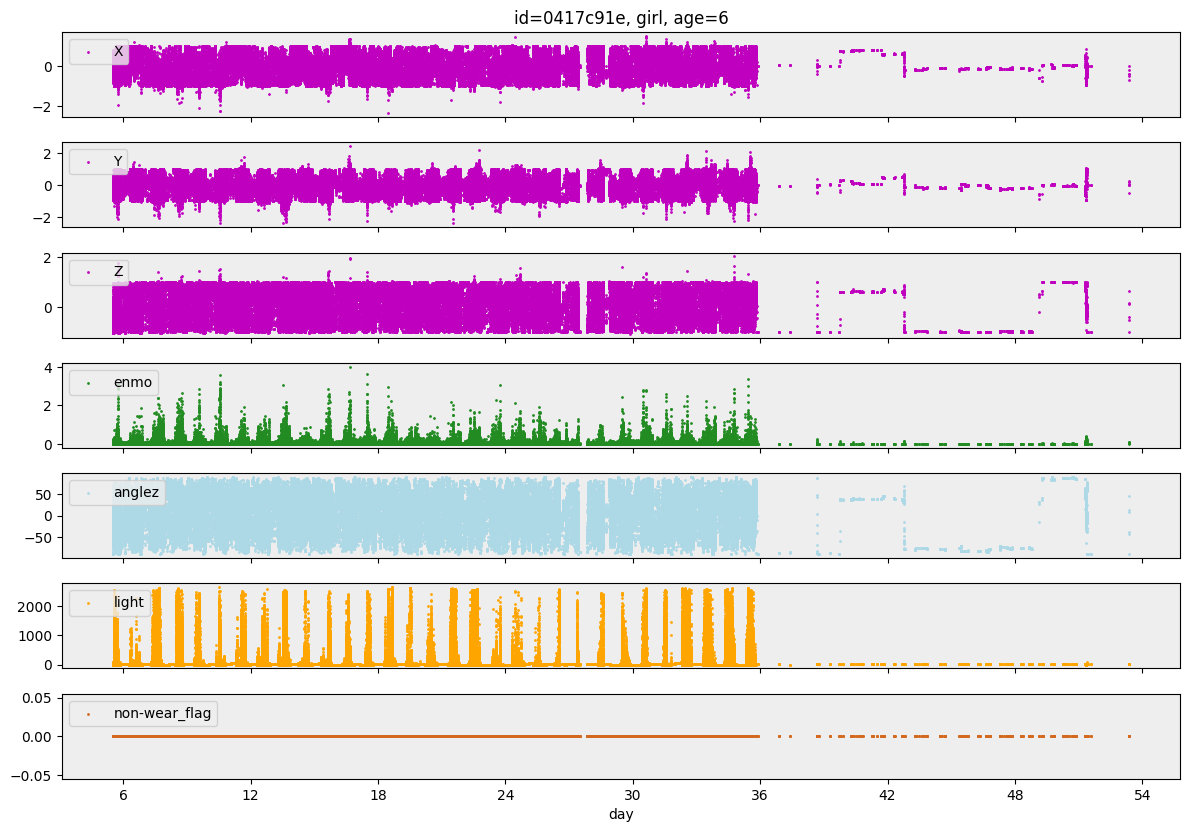

In [15]:
def analyze_actigraphy(id, only_one_week=False, small=False):
    actigraphy = pl.read_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')
    day = actigraphy.get_column('relative_date_PCIAT') + actigraphy.get_column('time_of_day') / 86400e9
    sample = train.filter(pl.col('id') == id)
    age = sample.get_column('Basic_Demos-Age').item()
    sex = ['boy', 'girl'][sample.get_column('Basic_Demos-Sex').item()]
    actigraphy = (
        actigraphy
        .with_columns(
            (day.diff() * 86400).alias('diff_seconds'),
            (np.sqrt(np.square(pl.col('X')) + np.square(pl.col('Y')) + np.square(pl.col('Z'))).alias('norm'))
        )
    )

    if only_one_week:
        start = np.ceil(day.min())
        mask = (start <= day.to_numpy()) & (day.to_numpy() <= start + 7*3)
        mask &= ~ actigraphy.get_column('non-wear_flag').cast(bool).to_numpy()
    else:
        mask = np.full(len(day), True)
        
    if small:
        timelines = [
            ('enmo', 'forestgreen'),
            ('light', 'orange'),
        ]
    else:
        timelines = [
            ('X', 'm'),
            ('Y', 'm'),
            ('Z', 'm'),
#             ('norm', 'c'),
            ('enmo', 'forestgreen'),
            ('anglez', 'lightblue'),
            ('light', 'orange'),
            ('non-wear_flag', 'chocolate')
    #         ('diff_seconds', 'k'),
        ]
        
    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(day.to_numpy()[mask],
                   actigraphy.get_column(feature).to_numpy()[mask],
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    axs[-1].set_xlabel('day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'id={id}, {sex}, age={age}')
    plt.show()

analyze_actigraphy('0417c91e', only_one_week=False)

# 資料預處理

In [16]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    
    # 提取所需的統計特徵
    mean_values = df.mean().values
    std_values = df.std().values
    min_values = df.min().values
    max_values = df.max().values
    
    # 計算活動比例
    active_ratio = (df[['X', 'Y', 'Z']] != 0).mean().values
    still_ratio = (df['enmo'] < 0.01).mean()
    
    # 合併特徵
    features = np.concatenate([mean_values, std_values, min_values, max_values, active_ratio, [still_ratio]])
    
    # 創建特徵名稱
    columns = list(df.columns)
    feature_names = (
        [f"{col}_mean" for col in columns] +
        [f"{col}_std" for col in columns] +
        [f"{col}_min" for col in columns] +
        [f"{col}_max" for col in columns] +
        [f"{col}_active_ratio" for col in ['X', 'Y', 'Z']] +
        ['enmo_still_ratio']
    )
    
    return features, feature_names, filename.split('=')[1]



def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        # 修改：接收返回的特徵值、特徵名稱和 ID
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    # 解壓結果
    stats_list, feature_names_list, indexes = zip(*results)
    
    # 獲取統一的特徵名稱（假設所有檔案的特徵名稱相同）
    feature_names = feature_names_list[0]
    
    # 構建 DataFrame
    df = pd.DataFrame(stats_list, columns=feature_names)
    df['id'] = indexes
    
    return df


In [17]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

100%|██████████| 2/2 [00:00<00:00, 18.74it/s]


In [18]:
train_ts

,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,X_active_ratio,Y_active_ratio,Z_active_ratio,enmo_still_ratio,id
0,-0.054638,-0.163923,-0.114302,0.045252,-7.805897,0.000000,46.009533,4027.514893,5.415475e+13,4.438860,2.000000,30.202068,0.633126,0.513286,0.500372,0.132576,34.917873,0.000000,205.862213,108.451317,1.876976e+13,1.825557,0.000000,11.773107,-1.812031,-2.631380,-1.798073,0.0,-89.987045,0.0,0.0,3829.000000,0.000000e+00,1.0,2.0,15.0,1.850391,3.580182,1.738203,5.314874,89.422226,0.0,2626.199951,4187.0,8.639500e+13,7.0,2.0,57.0,0.999980,0.99998,0.999980,0.296920,0745c390
1,0.113277,0.093139,-0.106038,0.028960,-6.065619,0.046508,56.437958,3829.466064,4.331149e+13,3.840885,2.000000,232.909103,0.507897,0.541129,0.603787,0.096825,44.034721,0.208482,206.625092,167.600983,2.509136e+13,1.957999,0.000000,5.701968,-1.807955,-2.887664,-1.004992,0.0,-89.654587,0.0,0.0,3098.166748,0.000000e+00,1.0,2.0,223.0,1.928769,3.234613,2.475326,3.966906,89.080330,1.0,2628.199951,4146.0,8.639500e+13,7.0,2.0,243.0,1.000000,1.00000,1.000000,0.611215,eaab7a96
2,-0.499738,0.046381,-0.181152,0.056544,-11.934993,0.000000,77.305130,4106.425781,4.481677e+13,3.148264,3.000000,100.144516,0.454021,0.510668,0.412588,0.140594,27.367514,0.000000,274.848145,50.734318,2.038156e+13,1.169176,0.000000,5.653936,-1.903281,-3.150104,-1.020313,0.0,-89.540176,0.0,0.0,3853.000000,4.500000e+10,1.0,3.0,97.0,1.021510,1.016589,1.746797,5.066334,86.987267,0.0,2618.199951,4183.0,8.636500e+13,7.0,3.0,134.0,0.999975,0.99995,0.999975,0.334800,8ec2cc63
3,0.007430,0.007583,-0.196510,0.053544,-12.847143,0.000000,9.369678,3958.604492,4.836642e+13,4.273992,2.303057,60.025017,0.586100,0.542189,0.474437,0.103401,32.552841,0.000000,54.104408,122.706810,1.868773e+13,2.023705,1.487018,7.396456,-1.684624,-2.405738,-1.023798,0.0,-89.968369,0.0,0.0,3468.000000,0.000000e+00,1.0,1.0,48.0,5.908000,2.083693,1.269051,6.134459,89.976074,0.0,2502.000000,6000.0,8.639500e+13,7.0,4.0,72.0,1.000000,1.00000,1.000000,0.250778,b2987a65
4,0.086653,-0.115162,-0.138969,0.040399,-11.009835,0.000000,5.049157,3992.347656,5.833895e+13,4.541829,4.000000,46.192024,0.509845,0.494897,0.639449,0.090201,47.933723,0.000000,15.590773,126.121590,2.146206e+13,2.081796,0.000000,18.615358,-1.675859,-1.071042,-1.012266,0.0,-89.770241,0.0,0.0,3815.083252,3.500000e+10,1.0,4.0,20.0,3.231563,1.033620,1.071875,2.774382,89.300034,0.0,1046.800049,4199.0,8.601500e+13,7.0,4.0,76.0,1.000000,0.99987,1.000000,0.325875,7b8842c3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,-0.067798,0.006292,0.201008,0.038587,13.204196,0.005480,8.857800,3851.464844,4.327464e+13,3.911399,4.000000,149.392853,0.591072,0.481551,0.565229,0.093812,38.950920,0.070666,53.159111,166.704880,2.502804e+13,1.951508,0.000000,6.595387,-1.407426,-1.014350,-1.020204,0.0,-89.820068,0.0,0.0,3098.166748,0.000000e+00,1.0,4.0,138.0,1.491908,3.059684,2.099614,3.669502,89.025551,1.0,2576.399902,4191.0,8.639500e+13,7.0,4.0,161.0,1.000000,1.00000,1.000000,0.468449,cd68643b
992,0.097154,-0.356072,-0.043487,0.036847,-6.769969,0.000000,35.192787,4002.345703,4.686980e+13,3.730544,1.548954,101.264435,0.269882,0.530971,0.701824,0.068496,51.202816,0.000000,77.692101,166.620529,7.143143e+12,1.230283,0.497806,25.009487,-1.064844,-1.012995,-1.033333,0.0,-89.104843

In [19]:
train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,NaN,71.0,70.0,104.0,NaN,NaN,NaN,NaN,Fall,16.0,0.0,18.0,1.0,19.9,2.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,Fall,3.0,4.52277,16.3642,1206.880,2051.70,19.46110,70.8117,14.0629,2.30138,11.58830,1.0,33.3709,17.97970,66.2889,29.7790,52.8320,NaN,NaN,Winter,3.260,Winter,3.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,32.

###### 

In [20]:
train['sii'].value_counts()

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

In [21]:
# 定義季節類型的映射字典
season_mapping = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3}

# 找到所有以 Season 結尾的欄位
season_columns = [col for col in train.columns if col.endswith('Season')]

# 將這些列的值轉換為數值
for col in season_columns:
    train[col] = train[col].map(season_mapping)

train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,2,5,0,3.0,51.0,2.0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,2.0,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,2.0,3.0,2.0
1,000fd460,1,9,0,NaN,NaN,2.0,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,2.0,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,3.0,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,2.0,2.340,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,46.0,64.0,1.0,0.0,0.0
2,00105258,1,10,1,2.0,71.0,2.0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,2.0,5.0,7.0,33.0,2.0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.170,2.0,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,2.0,38.0,54.0,1.0,2.0,0.0
3,00115b9f,3,9,0,2.0,71.0,1.0,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,1.0,6.0,9.0,37.0,1.0,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,1.0,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,3.0,2.451,1.0,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,1.0,31.0,45.0,3.0,0.0,1.0
4,0016bb22,0,18,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,2,13,0,0.0,60.0,2.0,16.362460,59.5,82.4,NaN,71.0,70.0,104.0,NaN,NaN,NaN,NaN,2.0,16.0,0.0,18.0,1.0,19.9,2.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,2.0,3.0,4.52277,16.3642,1206.880,2051.70,19.46110,70.8117,14.0629,2.30138,11.58830,1.0,33.3709,17.97970,66.2889,29.7790,52.8320,NaN,NaN,3.0,3.260,3.0,3.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,32.0,3.0,35.0,50.0,2.0,1.0,1.0
3956,ffa9794a,3,10,0,NaN,NaN,0.0,18.764678,53.5,76.4,27.0,60.0,78.0,118.

In [22]:
# 找到 test 中的列名
test_columns = set(test.columns)

# 找到 train 中需要保留的列（目標列 'sii' 和 test 中存在的列）
columns_to_keep = [col for col in train.columns if col in test_columns or col == 'sii']

# 篩選 train 中需要保留的列
filtered_train = train[columns_to_keep]
filtered_train = filtered_train[filtered_train['sii'].notnull()]
# 打印結果
print(f"原始 train 大小: {train.shape}")
print(f"篩選後 train 大小: {filtered_train.shape}")
print(f"保留的列: {columns_to_keep}")

原始 train 大小: (3960, 82)
篩選後 train 大小: (2736, 60)
保留的列: ['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-Sea

In [23]:
# 獲取每列的非空值數量
non_null_counts = filtered_train.notnull().sum()

# 計算總行數
total_rows = len(filtered_train)

# 計算缺失比率
train_null_ratio = 1 - (non_null_counts / total_rows)

# 設定閾值
threshold = 0.3

# 篩選出 null_ratio 小於等於閾值的列
columns_to_keep_train = train_null_ratio[train_null_ratio <= threshold].index.tolist()

# 保留篩選出的列
filtered_train = filtered_train[columns_to_keep_train]

# 打印結果
print(f"保留的列: {columns_to_keep_train}")
print(f"篩選後的 train 大小: {filtered_train.shape}")


保留的列: ['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_TL', 'SDS-Season', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday', 'sii']
篩選後的 train 大小: (2736, 22)


In [24]:
# 定義季節類型的映射字典
season_mapping = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3}

# 找到所有以 Season 結尾的欄位
season_columns = [col for col in test.columns if col.endswith('Season')]

# 將這些列的值轉換為數值
for col in season_columns:
    test[col] = test[col].map(season_mapping)

test

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,2,5,0,3.0,51.0,2.0,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0
1,000fd460,1,9,0,NaN,NaN,2.0,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,2.0,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,3.0,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,2.0,2.340,2.0,46.0,64.0,1.0,0.0
2,00105258,1,10,1,2.0,71.0,2.0,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,2.0,5.0,7.0,33.0,2.0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.170,2.0,38.0,54.0,1.0,2.0
3,00115b9f,3,9,0,2.0,71.0,1.0,18.292347,56.00,81.6,NaN,60.0,97.0,117.0,1.0,6.0,9.0,37.0,1.0,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,1.0,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,3.0,2.451,1.0,31.0,45.0,3.0,0.0
4,0016bb22,0,18,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001f3379,0,13,1,3.0,50.0,1.0,22.279952,59.50,112.2,NaN,60.0,73.0,102.0,NaN,NaN,NaN,NaN,1.0,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,1.0,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,NaN,NaN,0.0,4.110,1.0,40.0,56.0,0.0,0.0
6,0038ba98,2,10,0,NaN,NaN,2.0,19.660760,55.00,84.6,NaN,123.0,83.0,163.0,NaN,NaN,NaN,NaN,2.0,9.0,1.0,NaN,NaN,NaN,NaN,2.0,0.0,11.0,1.0,11.0,1.0,11.0,1.0,2.0,2.0,3.78271,19.6629,1135.860,1817.38,16.32750,63.2470,14.7000,4.96291,21.35300,2.0,30.8936,16.02590,59.4643,26.1957,47.2211,NaN,NaN,3.0,3.670,3.0,27.0,40.0,2.0,3.0
7,0068a485,2,10,1,NaN,NaN,2.0,16.861286,59.25,84.2,27.0,71.0,90.0,116.0,NaN,NaN,NaN,NaN,2.0,0.0,0.0,12.6,2.0,11.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,3.0,4.05726,16.8631,1180.040,1888.06,21.94000,67.9527,13.6092,3.25395,16.24740,2.0,28.5367,17.47600,63.8954,28.7680,50.4767,NaN,NaN,2.0,1.270,NaN,NaN,NaN,2.0,2.0
8,0069fbed,1,15,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0
9,0083e397,1,19,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# 合併兩個 DataFrame，根據 id
# merged_train = pd.merge(filtered_train, train_ts, on='id', how='inner')
merged_train = pd.merge(filtered_train, train_ts, on='id', how='left')


# 將 id 設置為索引
merged_train.set_index('id', inplace=True)

# 打印結果
merged_train

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_TL,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,X_active_ratio,Y_active_ratio,Z_active_ratio,enmo_still_ratio
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00008ff9,2,5,0,3.0,51.0,2.0,16.877316,46.0,50.8,NaN,NaN,NaN,2.0,0.0,6.0,NaN,NaN,NaN,2.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000fd460,1,9,0,NaN,NaN,2.0,14.035590,48.0,46.0,75.0,70.0,122.0,2.0,3.0,3.0,2.0,46.0,64.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00105258,1,10,1,2.0,71.0,2.0,16.648696,56.5,75.6,65.0,94.0,117.0,2.0,20.0,5.0,2.0,38.0,54.0,1.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00115b9f,3,9,0,2.0,71.0,1.0,18.292347,56.0,81.6,60.0,97.0,117.0,1.0,18.0,7.0,1.0,31.0,45.0,3.0,0.0,1.0,-0.316384,0.016009,-0.167890,0.047388,-10.580416,0.000000,42.296310,4053.579102,5.046215e+13,4.470182,3.0,53.201683,0.453665,0.502702,0.585710,0.106351,42.947170,0.000000,208.168976,112.404045,1.942842e+13,1.931421,0.0,14.244915,-1.746094,-2.905339,-1.048372,0.0,-89.833092,0.0,0.0,3824.000000,5.500000e+10,1.0,3.0,41.0,1.507865,1.666354,1.546979,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0,1.0,0.999977,0.999954,0.311401
001f3379,0,13,1,3.0,50.0,1.0,22.279952,59.5,112.2,60.0,73.0,102.0,1.0,12.0,8.0,1.0,40.0,56.0,0.0,0.0,1.0,-0.004272,0.016859,-0.631731,0.011926,-55.630768,0.655708,16.771982,3838.189453,4.321212e+13,3.909848,3.0,79.435593,0.351545,0.303812,0.623476,0.024331,50.303635,0.468723,95.327438,155.573868,2.497264e+13,1.946892,0.0,6.634319,-1.038711,-1.522690,-1.018787,0.0,-88.761833,0.0,0.0,3098.166748,0.000000e+00,1.0,3.0,68.0,1.034351,1.946303,1.146284,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0,1.0,1.000000,1.000000,0.550079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff6c2bb8,2,8,0,NaN,NaN,2.0,17.139810,52.5,67.2,60.0,65.0,112.0,2.0,0.0,12.0,2.0,41.0,58.0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ff759544,1,7,1,NaN,NaN,1.0,13.927006,48.5,46.6,65.0,75.0,105.0,1.0,0.0,4.5,1.0,48.0,67.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

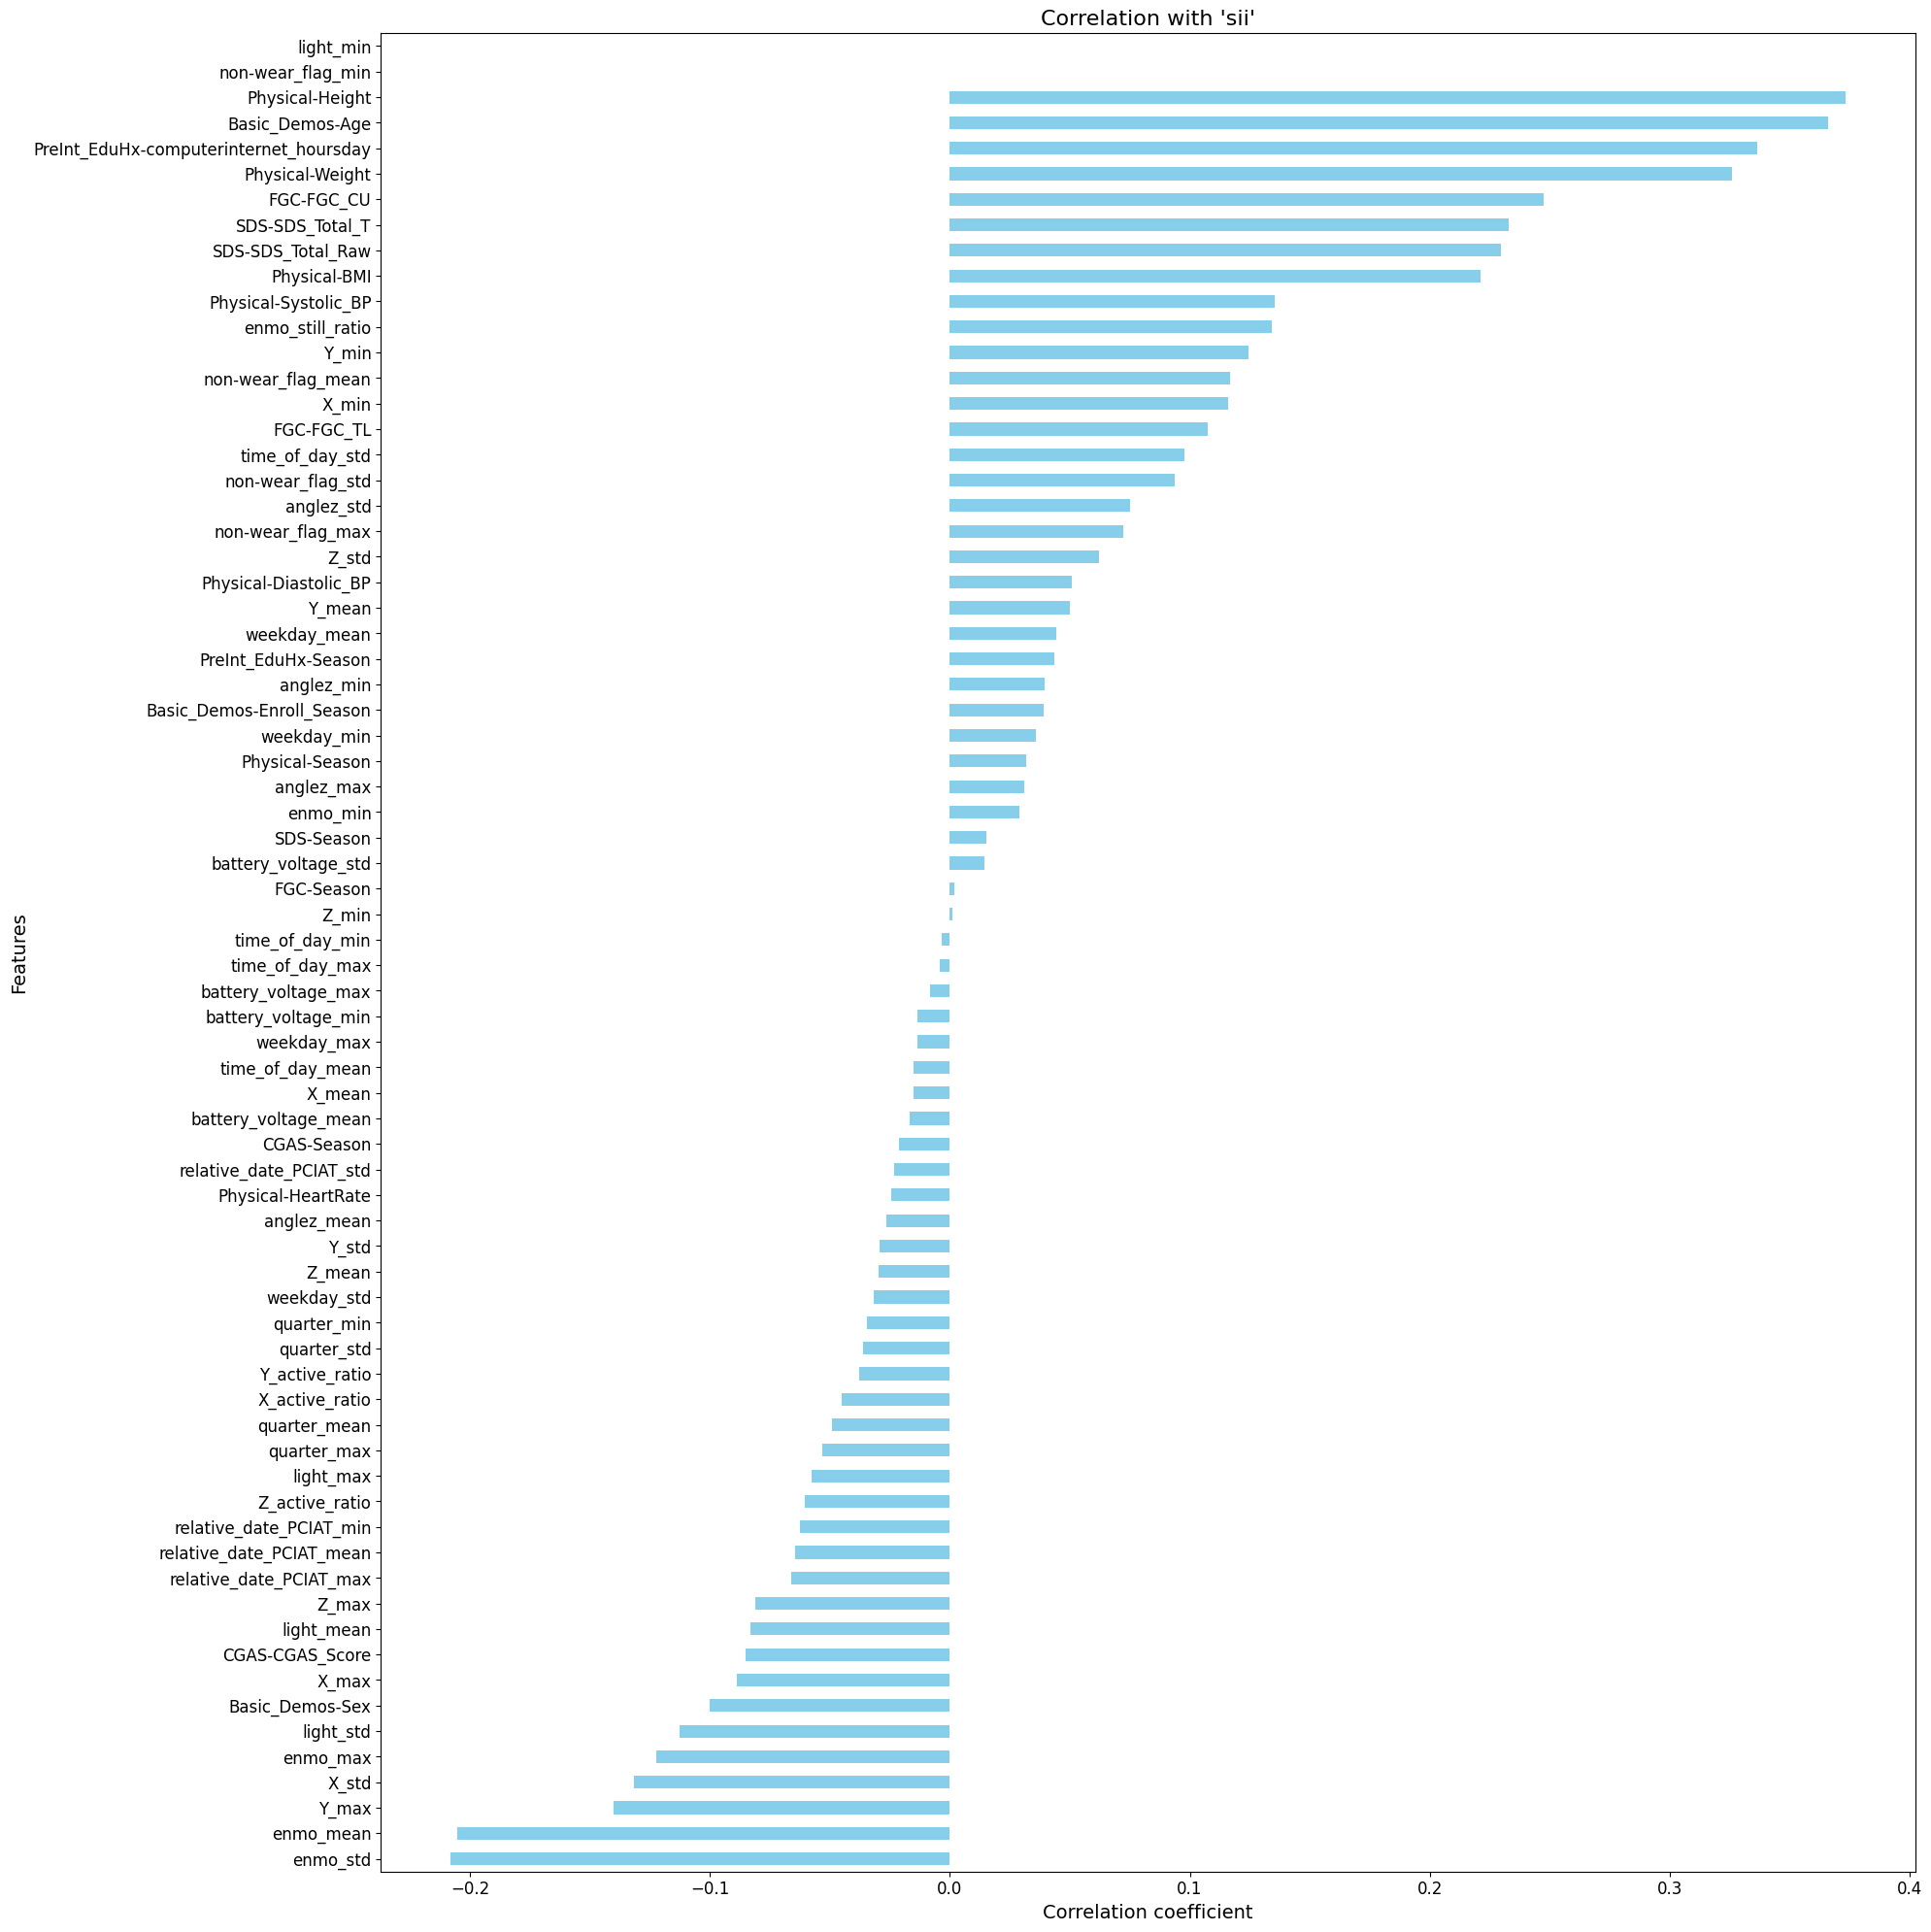

其他欄位與 'sii' 的相關係數：
Basic_Demos-Enroll_Season    0.038949
Basic_Demos-Age              0.365990
Basic_Demos-Sex             -0.100148
CGAS-Season                 -0.021175
CGAS-CGAS_Score             -0.085261
                               ...   
relative_date_PCIAT_max     -0.066038
X_active_ratio              -0.045275
Y_active_ratio              -0.037629
Z_active_ratio              -0.060406
enmo_still_ratio             0.134221
Name: sii, Length: 72, dtype: float64


In [26]:
import matplotlib.pyplot as plt
# 篩選數值型列
numeric_columns = merged_train.select_dtypes(include=['number']).columns

# 計算相關係數
correlation_with_sii = merged_train[numeric_columns].corr()['sii'].drop('sii')

# 設置圖形大小
plt.figure(figsize=(20, 20))  # 調整寬和高

# 繪製條形圖
correlation_with_sii.sort_values().plot(kind='barh', color='skyblue')

# 添加標題和軸標籤
plt.title("Correlation with 'sii'", fontsize=16)  # 設置標題字體大小
plt.xlabel("Correlation coefficient", fontsize=14)  # 設置 X 軸標籤字體大小
plt.ylabel("Features", fontsize=14)  # 設置 Y 軸標籤字體大小

# 調整刻度字體大小
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 顯示圖形
plt.tight_layout()  # 自動調整子圖參數以防止文字重疊
plt.show()

# 打印相關係數
print("其他欄位與 'sii' 的相關係數：")
print(correlation_with_sii)


In [27]:
# 計算相關係數
correlation_with_sii = merged_train.corr()['sii']

# 篩選相關性大於 0.1 的列
columns_to_keep = correlation_with_sii[correlation_with_sii.abs() > 0.1].index.tolist()

# 保留相關列
filtered_train = merged_train[columns_to_keep]

# 打印結果
print(f"保留的列: {columns_to_keep}")
print(f"篩選後的 train 大小: {filtered_train.shape}")


保留的列: ['Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_TL', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'sii', 'enmo_mean', 'non-wear_flag_mean', 'X_std', 'enmo_std', 'light_std', 'X_min', 'Y_min', 'Y_max', 'enmo_max', 'enmo_still_ratio']
篩選後的 train 大小: (2736, 22)


In [28]:
# 將 'sii' 欄位移到最後
columns = [col for col in filtered_train.columns if col != 'sii']  # 除了 'sii' 的其他列
columns.append('sii')  # 將 'sii' 加到最後
filtered_train = filtered_train[columns]  # 重新排列列順序

In [29]:
filtered_train

,Basic_Demos-Age,Basic_Demos-Sex,Physical-BMI,Physical-Height,Physical-Weight,Physical-Systolic_BP,FGC-FGC_CU,FGC-FGC_TL,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,enmo_mean,non-wear_flag_mean,X_std,enmo_std,light_std,X_min,Y_min,Y_max,enmo_max,enmo_still_ratio,sii
id,,,,,,,,,,,,,,,,,,,,,,
00008ff9,5,0,16.877316,46.0,50.8,NaN,0.0,6.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
000fd460,9,0,14.035590,48.0,46.0,122.0,3.0,3.0,46.0,64.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
00105258,10,1,16.648696,56.5,75.6,117.0,20.0,5.0,38.0,54.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
00115b9f,9,0,18.292347,56.0,81.6,117.0,18.0,7.0,31.0,45.0,0.0,0.047388,0.000000,0.453665,0.106351,208.168976,-1.746094,-2.905339,1.666354,4.004276,0.311401,1.0
001f3379,13,1,22.279952,59.5,112.2,102.0,12.0,8.0,40.0,56.0,0.0,0.011926,0.655708,0.351545,0.024331,95.327438,-1.038711,-1.522690,1.946303,2.952888,0.550079,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff6c2bb8,8,0,17.139810,52.5,67.2,112.0,0.0,12.0,41.0,58.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
ff759544,7,1,13.927006,48.5,46.6,105.0,0.0,4.5,48.0,67.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
ff8a2de4,13,0,16.362460,59.5,82.4,104.0,16.0,12.0,35.0,50.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [30]:
merged_test = pd.merge(test, test_ts, on='id', how='left')
# 將 id 設置為索引
merged_test.set_index('id', inplace=True)
merged_test

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,X_active_ratio,Y_active_ratio,Z_active_ratio,enmo_still_ratio
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00008ff9,2,5,0,3.0,51.0,2.0,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000fd460,1,9,0,NaN,NaN,2.0,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,2.0,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,3.0,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,2.0,2.340,2.0,46.0,64.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00105258,1,10,1,2.0,71.0,2.0,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,2.0,5.0,7.0,33.0,2.0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.170,2.0,38.0,54.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00115b9f,3,9,0,2.0,71.0,1.0,18.292347,56.00,81.6,NaN,60.0,97.0,117.0,1.0,6.0,9.0,37.0,1.0,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,1.0,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,3.0,2.451,1.0,31.0,45.0,3.0,0.0,-0.316384,0.016009,-0.167890,0.047388,-10.580416,0.000000,42.296310,4053.579102,5.046215e+13,4.470182,3.0,53.201683,0.453665,0.502702,0.585710,0.106351,42.947170,0.000000,208.168976,112.404045,1.942842e+13,1.931421,0.0,14.244915,-1.746094,-2.905339,-1.048372,0.0,-89.833092,0.0,0.0,3824.000000,5.500000e+10,1.0,3.0,41.0,1.507865,1.666354,1.546979,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0,1.0,0.999977,0.999954,0.311401
0016bb2

In [31]:
merged_test = merged_test[['Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_TL', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'enmo_mean', 'non-wear_flag_mean', 'X_std', 'enmo_std', 'light_std', 'X_min', 'Y_min', 'Y_max', 'enmo_max', 'enmo_still_ratio']]
merged_test

,Basic_Demos-Age,Basic_Demos-Sex,Physical-BMI,Physical-Height,Physical-Weight,Physical-Systolic_BP,FGC-FGC_CU,FGC-FGC_TL,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,enmo_mean,non-wear_flag_mean,X_std,enmo_std,light_std,X_min,Y_min,Y_max,enmo_max,enmo_still_ratio
id,,,,,,,,,,,,,,,,,,,,,
00008ff9,5,0,16.877316,46.00,50.8,NaN,0.0,6.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000fd460,9,0,14.035590,48.00,46.0,122.0,3.0,3.0,46.0,64.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00105258,10,1,16.648696,56.50,75.6,117.0,20.0,5.0,38.0,54.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00115b9f,9,0,18.292347,56.00,81.6,117.0,18.0,7.0,31.0,45.0,0.0,0.047388,0.000000,0.453665,0.106351,208.168976,-1.746094,-2.905339,1.666354,4.004276,0.311401
0016bb22,18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001f3379,13,1,22.279952,59.50,112.2,102.0,12.0,8.0,40.0,56.0,0.0,0.011926,0.655708,0.351545,0.024331,95.327438,-1.038711,-1.522690,1.946303,2.952888,0.550079
0038ba98,10,0,19.660760,55.00,84.6,163.0,9.0,11.0,27.0,40.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0068a485,10,1,16.861286,59.25,84.2,116.0,0.0,4.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0069fbed,15,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 模型預測

In [32]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 初始化存儲模型結果的字典
model_results = {}


# Random Forest

分類報告：
              precision    recall  f1-score   support

         0.0       0.70      0.83      0.76       336
         1.0       0.30      0.27      0.28       131
         2.0       0.34      0.17      0.22        72
         3.0       0.67      0.22      0.33         9

    accuracy                           0.60       548
   macro avg       0.50      0.37      0.40       548
weighted avg       0.56      0.60      0.57       548

準確率: 0.60


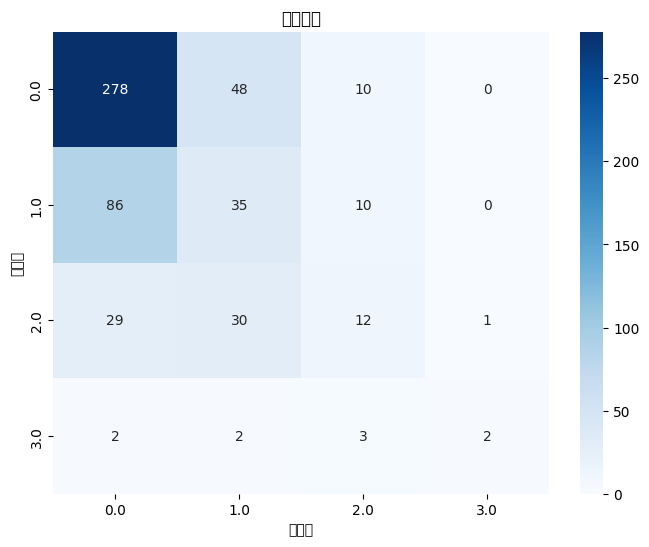

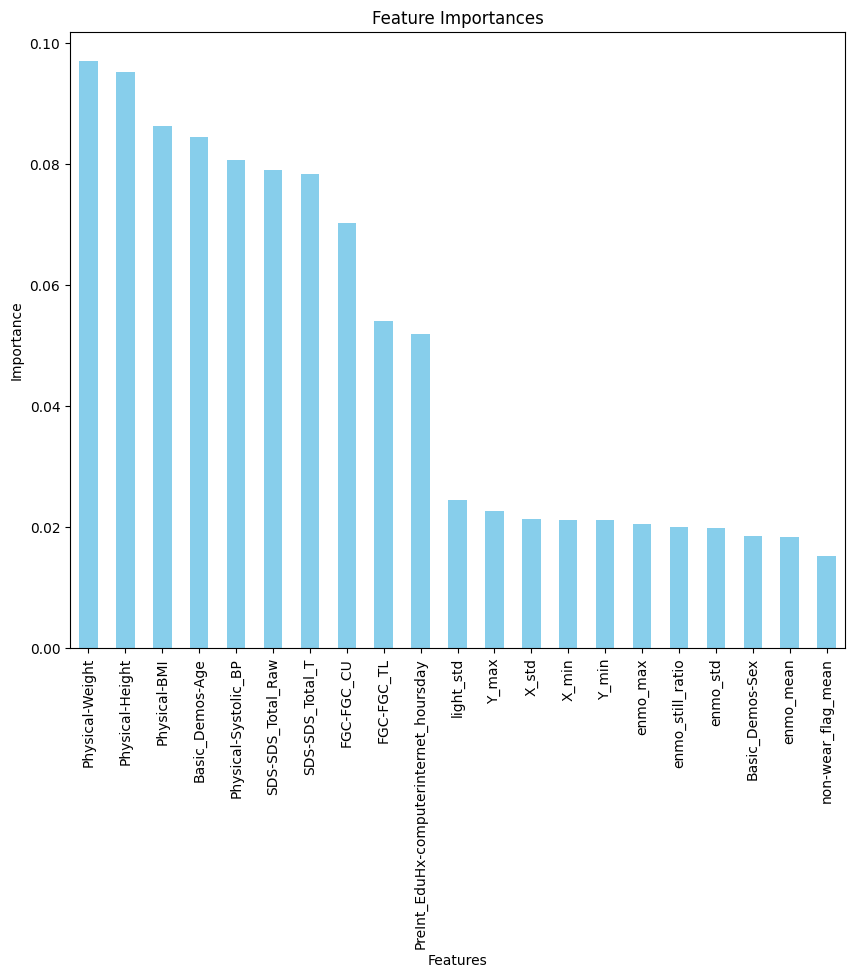

最重要的特徵：
Physical-Weight                           0.096992
Physical-Height                           0.095198
Physical-BMI                              0.086226
Basic_Demos-Age                           0.084432
Physical-Systolic_BP                      0.080745
SDS-SDS_Total_Raw                         0.078966
SDS-SDS_Total_T                           0.078349
FGC-FGC_CU                                0.070271
FGC-FGC_TL                                0.054049
PreInt_EduHx-computerinternet_hoursday    0.051836
dtype: float64


In [33]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 分離特徵和目標
X = filtered_train.drop('sii', axis=1)
y = filtered_train['sii']

# 填補缺失值（這裡用均值作為填補策略）
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# 初始化 Random Forest 模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# 評估模型
print("分類報告：")
print(classification_report(y_test, y_pred))
print(f"準確率: {accuracy_score(y_test, y_pred):.2f}")

# 混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title("混淆矩陣")
plt.xlabel("預測值")
plt.ylabel("真實值")
plt.show()

# 特徵重要性
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
feature_importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

print("最重要的特徵：")
print(feature_importances.head(10))

import joblib

# 保存訓練好的模型
joblib.dump(rf_model, "random_forest_model.pkl")

model_name = "Random Forest"
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

model_results[model_name] = {
    "accuracy": accuracy,
    "classification_report": classification_rep,
    "confusion_matrix": conf_matrix
}

In [34]:
test_ids = merged_test.index
# 載入保存的模型
rf_model_loaded = joblib.load("random_forest_model.pkl")

# 假設測試資料已經進行相同的預處理
# 測試資料需要先填補缺失值
X_test_imputed = imputer.transform(merged_test)  # `X_test_new` 是新的測試資料

# 使用載入的模型進行預測
y_pred_new = rf_model_loaded.predict(X_test_imputed)

# 顯示預測結果
print("新的測試資料預測值：")
print(y_pred_new)

submission = pd.DataFrame({
    "id": test_ids,  # 測試資料的 ID 欄位
    "sii": y_pred_new
})

# 保存為 CSV 檔案
submission.to_csv("submission.csv", index=False)

新的測試資料預測值：
[2. 0. 0. 1. 0. 1. 0. 0. 2. 0. 1. 0. 1. 1. 1. 2. 0. 0. 0. 1.]


# Xgboost

分類報告：
              precision    recall  f1-score   support

         0.0       0.72      0.82      0.77       336
         1.0       0.30      0.30      0.30       131
         2.0       0.27      0.14      0.18        72
         3.0       0.00      0.00      0.00         9

    accuracy                           0.59       548
   macro avg       0.32      0.31      0.31       548
weighted avg       0.55      0.59      0.57       548

準確率: 0.59


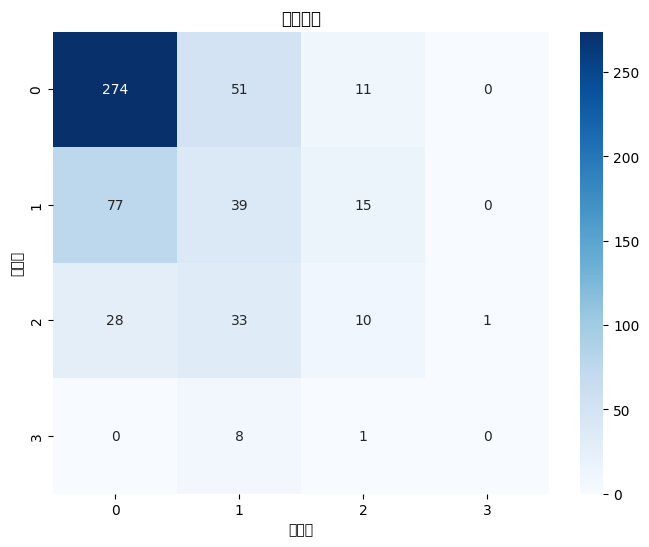

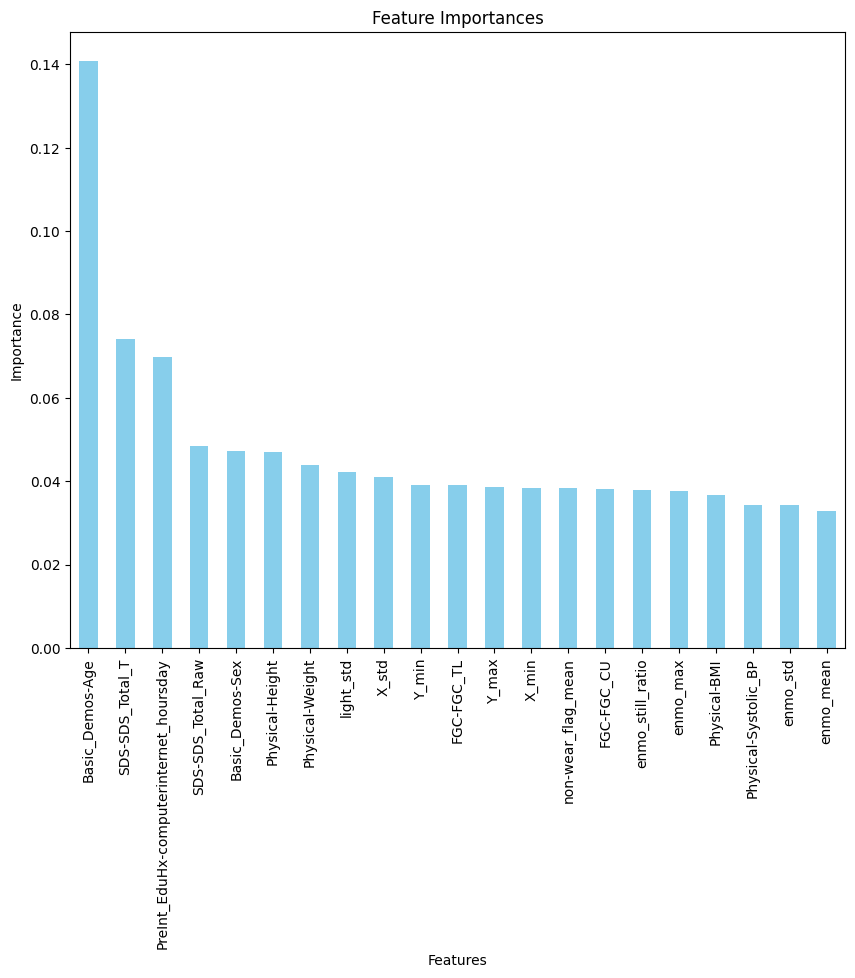

最重要的特徵：
Basic_Demos-Age                           0.140710
SDS-SDS_Total_T                           0.074192
PreInt_EduHx-computerinternet_hoursday    0.069736
SDS-SDS_Total_Raw                         0.048525
Basic_Demos-Sex                           0.047130
Physical-Height                           0.047122
Physical-Weight                           0.043966
light_std                                 0.042305
X_std                                     0.040919
Y_min                                     0.039124
dtype: float32


In [35]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



# 分離特徵和目標
X = filtered_train.drop('sii', axis=1)
y = filtered_train['sii']

# # 填補缺失值
# imputer = SimpleImputer(strategy='mean')
# X_imputed = imputer.fit_transform(X)

# 基於模型的填補缺失值
imputer = IterativeImputer(max_iter=10, random_state=42)
X_imputed = imputer.fit_transform(X)

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# 訓練 XGBoost 模型
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# 評估模型
print("分類報告：")
print(classification_report(y_test, y_pred))
print(f"準確率: {accuracy_score(y_test, y_pred):.2f}")

# 混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=xgb_model.classes_, yticklabels=xgb_model.classes_)
plt.title("混淆矩陣")
plt.xlabel("預測值")
plt.ylabel("真實值")
plt.show()

# 特徵重要性
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
feature_importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

print("最重要的特徵：")
print(feature_importances.head(10))

# 保存模型
joblib.dump(xgb_model, "xgboost_model.pkl")

model_name = "Xgboost"
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

model_results[model_name] = {
    "accuracy": accuracy,
    "classification_report": classification_rep,
    "confusion_matrix": conf_matrix
}

In [36]:
test_ids = merged_test.index
# 載入保存的模型
xgb_model_loaded = joblib.load("xgboost_model.pkl")

# 假設測試資料已經進行相同的預處理
# 測試資料需要先填補缺失值
X_test_imputed = imputer.transform(merged_test)  # `X_test_new` 是新的測試資料

# 使用載入的模型進行預測
y_pred_new = xgb_model_loaded.predict(X_test_imputed)

# 顯示預測結果
print("新的測試資料預測值：")
print(y_pred_new)

submission = pd.DataFrame({
    "id": test_ids,  # 測試資料的 ID 欄位
    "sii": y_pred_new
})

# 保存為 CSV 檔案
submission.to_csv("submission.csv", index=False)

新的測試資料預測值：
[2 0 0 1 2 1 0 0 2 0 1 0 1 1 2 2 0 0 0 1]


# LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4284
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 21
[LightGBM] [Info] Start training from score -0.553465
[LightGBM] [Info] Start training from score -1.295482
[LightGBM] [Info] Start training from score -1.967158
[LightGBM] [Info] Start training from score -4.471867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

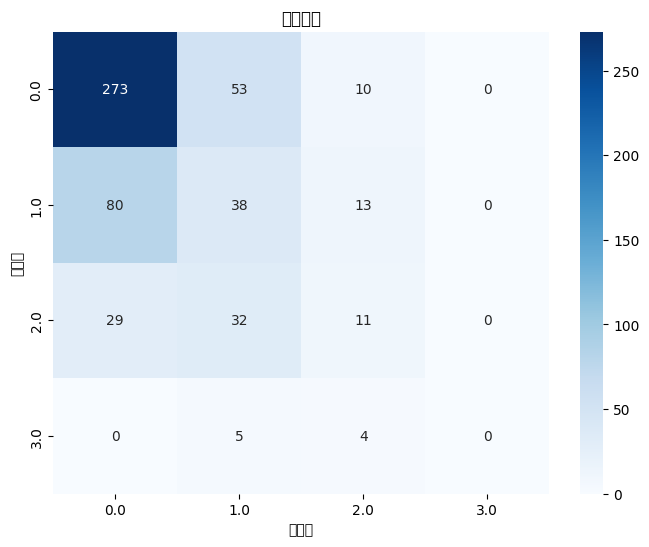

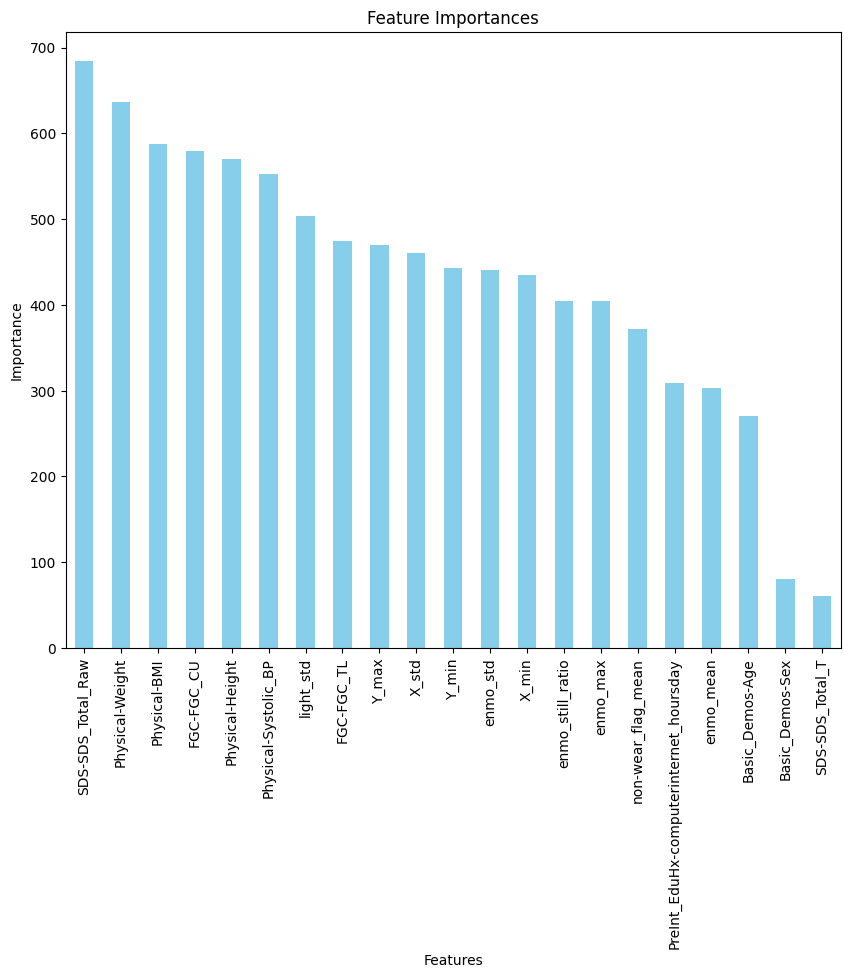

最重要的特徵：
SDS-SDS_Total_Raw       684
Physical-Weight         637
Physical-BMI            588
FGC-FGC_CU              580
Physical-Height         570
Physical-Systolic_BP    553
light_std               504
FGC-FGC_TL              475
Y_max                   470
X_std                   460
dtype: int32


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier

# 分離特徵和目標
X = filtered_train.drop('sii', axis=1)
y = filtered_train['sii']

# # 填補缺失值
# imputer = SimpleImputer(strategy='mean')
# X_imputed = imputer.fit_transform(X)

# 基於模型的填補缺失值
imputer = IterativeImputer(max_iter=10, random_state=42)
X_imputed = imputer.fit_transform(X)

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# 訓練 LightGBM 模型
lgb_model = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

# 評估模型
print("分類報告：")
print(classification_report(y_test, y_pred))
print(f"準確率: {accuracy_score(y_test, y_pred):.2f}")

# 混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lgb_model.classes_, yticklabels=lgb_model.classes_)
plt.title("混淆矩陣")
plt.xlabel("預測值")
plt.ylabel("真實值")
plt.show()

# 特徵重要性
feature_importances = pd.Series(lgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
feature_importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

print("最重要的特徵：")
print(feature_importances.head(10))

# 保存模型
joblib.dump(lgb_model, "lgb_model.pkl")

model_name = "LightGBM"
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

model_results[model_name] = {
    "accuracy": accuracy,
    "classification_report": classification_rep,
    "confusion_matrix": conf_matrix
}

In [38]:
test_ids = merged_test.index
# 載入保存的模型
lgb_model_loaded = joblib.load("lgb_model.pkl")

# 假設測試資料已經進行相同的預處理
# 測試資料需要先填補缺失值
X_test_imputed = imputer.transform(merged_test)  # `X_test_new` 是新的測試資料

# 使用載入的模型進行預測
y_pred_new = lgb_model_loaded.predict(X_test_imputed)

# 顯示預測結果
print("新的測試資料預測值：")
print(y_pred_new)

submission = pd.DataFrame({
    "id": test_ids,  # 測試資料的 ID 欄位
    "sii": y_pred_new
})

# 保存為 CSV 檔案
submission.to_csv("submission.csv", index=False)

新的測試資料預測值：
[2. 0. 0. 1. 2. 1. 0. 0. 2. 2. 0. 0. 1. 1. 2. 2. 0. 1. 0. 1.]


# SVM

分類報告：
              precision    recall  f1-score   support

         0.0       0.68      0.91      0.78       336
         1.0       0.26      0.16      0.20       131
         2.0       0.35      0.10      0.15        72
         3.0       0.00      0.00      0.00         9

    accuracy                           0.61       548
   macro avg       0.32      0.29      0.28       548
weighted avg       0.53      0.61      0.55       548

準確率: 0.61


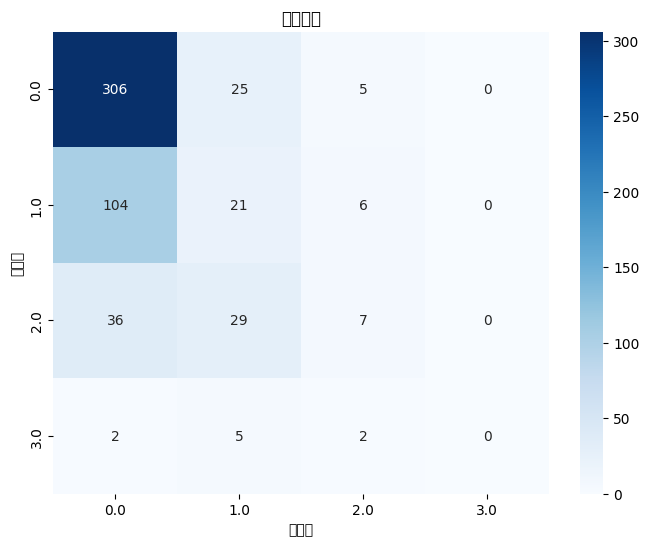

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 分離特徵和目標
X = filtered_train.drop('sii', axis=1)
y = filtered_train['sii']

# 基於模型的填補缺失值
imputer = IterativeImputer(max_iter=10, random_state=42)
X_imputed = imputer.fit_transform(X)


# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# 標準化數據
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 訓練 SVM 模型
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)

# 評估模型
print("分類報告：")
print(classification_report(y_test, y_pred))
print(f"準確率: {accuracy_score(y_test, y_pred):.2f}")

# 混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title("混淆矩陣")
plt.xlabel("預測值")
plt.ylabel("真實值")
plt.show()

# 保存模型
joblib.dump(svm_model, "svm_model.pkl")

model_name = "SVM"
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

model_results[model_name] = {
    "accuracy": accuracy,
    "classification_report": classification_rep,
    "confusion_matrix": conf_matrix
}

In [40]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import joblib

# 加載測試數據的 ID
test_ids = merged_test.index

# 加載保存的模型和標準化器
svm_model_loaded = joblib.load("svm_model.pkl")  # 保存的 SVM 模型

# 填補測試數據的缺失值
X_test_imputed = imputer.transform(merged_test)

# 標準化測試數據
X_test_scaled = scaler.transform(X_test_imputed)

# 使用載入的模型進行預測
y_pred_new = svm_model_loaded.predict(X_test_scaled)

# 顯示預測結果
print("新的測試資料預測值：")
print(y_pred_new)

# 創建提交文件
submission = pd.DataFrame({
    "id": test_ids,
    "sii": y_pred_new
})

# 保存為 CSV 文件
submission.to_csv("submission.csv", index=False)

print("預測完成，結果保存為 'submission.csv'")


新的測試資料預測值：
[0. 0. 0. 0. 1. 0. 0. 0. 2. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
預測完成，結果保存為 'submission.csv'


# MLP

分類報告：
              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70       336
         1.0       0.28      0.29      0.29       131
         2.0       0.21      0.21      0.21        72
         3.0       0.17      0.11      0.13         9

    accuracy                           0.53       548
   macro avg       0.34      0.33      0.33       548
weighted avg       0.52      0.53      0.53       548

準確率: 0.53


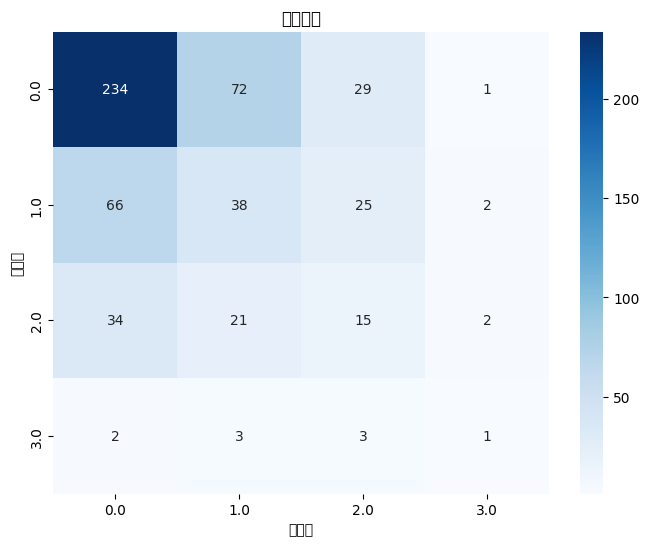

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 分離特徵和目標
X = filtered_train.drop('sii', axis=1)
y = filtered_train['sii']

# # 填補缺失值
# imputer = SimpleImputer(strategy='mean')
# X_imputed = imputer.fit_transform(X)

# 基於模型的填補缺失值
imputer = IterativeImputer(max_iter=10, random_state=42)
X_imputed = imputer.fit_transform(X)

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# 標準化數據
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 訓練 MLP 模型
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
mlp_model.fit(X_train_scaled, y_train)
y_pred = mlp_model.predict(X_test_scaled)

# 評估模型
print("分類報告：")
print(classification_report(y_test, y_pred))
print(f"準確率: {accuracy_score(y_test, y_pred):.2f}")

# 繪製混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlp_model.classes_, yticklabels=mlp_model.classes_)
plt.title("混淆矩陣")
plt.xlabel("預測值")
plt.ylabel("真實值")
plt.show()


# 保存模型
joblib.dump(mlp_model, "mlp_model.pkl")

model_name = "MLP Classifier"
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

model_results[model_name] = {
    "accuracy": accuracy,
    "classification_report": classification_rep,
    "confusion_matrix": conf_matrix
}

In [42]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import joblib

# 加載測試數據的 ID
test_ids = merged_test.index

# 加載保存的模型和處理器
mlp_model_loaded = joblib.load("mlp_model.pkl")  # 保存的 MLP 模型

# 填補測試數據的缺失值
X_test_imputed = imputer.transform(merged_test)

# 標準化測試數據
X_test_scaled = scaler.transform(X_test_imputed)

# 使用載入的模型進行預測
y_pred_new = mlp_model_loaded.predict(X_test_scaled)

# 顯示預測結果
print("新的測試資料預測值：")
print(y_pred_new)

# 創建提交文件
submission = pd.DataFrame({
    "id": test_ids,
    "sii": y_pred_new
})

# 保存為 CSV 文件
submission.to_csv("submission.csv", index=False)

print("預測完成，結果保存為 'submission.csv'")


新的測試資料預測值：
[2. 0. 0. 1. 0. 1. 0. 0. 2. 0. 1. 0. 1. 1. 2. 2. 0. 0. 0. 0.]
預測完成，結果保存為 'submission.csv'


# 模型性能比較

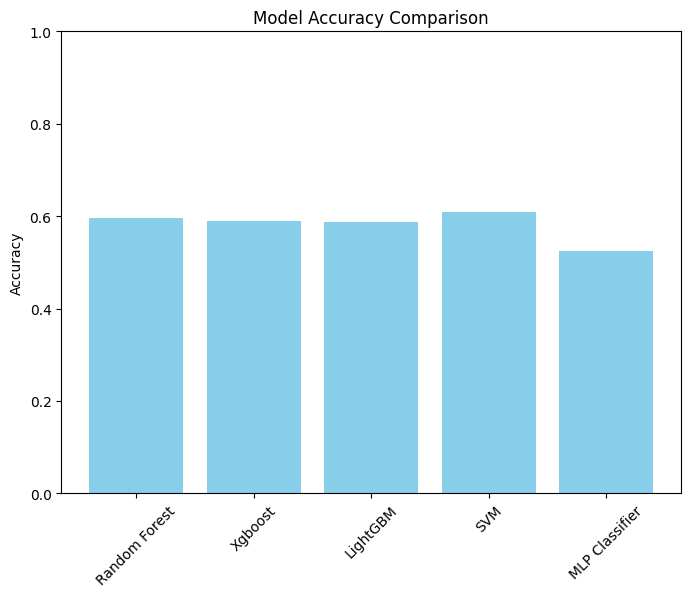

In [43]:
# 繪製準確率條形圖
accuracies = {model: result["accuracy"] for model, result in model_results.items()}
plt.figure(figsize=(8, 6))
plt.bar(accuracies.keys(), accuracies.values(), color="skyblue")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()


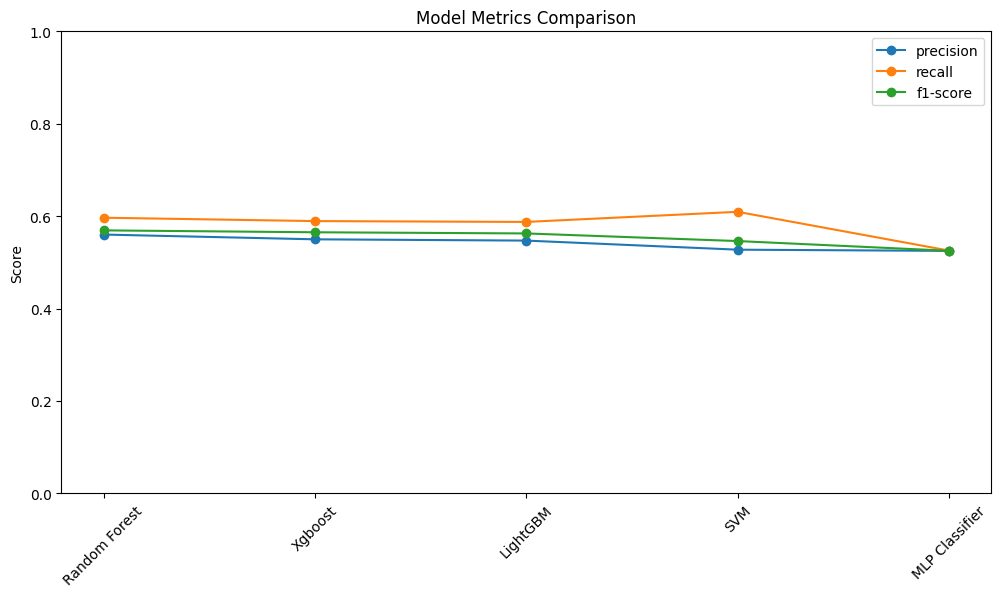

In [44]:
# 提取分類報告指標
metrics = ["precision", "recall", "f1-score"]
scores = {metric: [] for metric in metrics}

for model, result in model_results.items():
    for metric in metrics:
        avg_score = result["classification_report"]["weighted avg"][metric]
        scores[metric].append(avg_score)

# 繪製指標比較圖
x = list(model_results.keys())
plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot(x, scores[metric], marker="o", label=metric)

plt.title("Model Metrics Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.xticks(rotation=45)
plt.show()


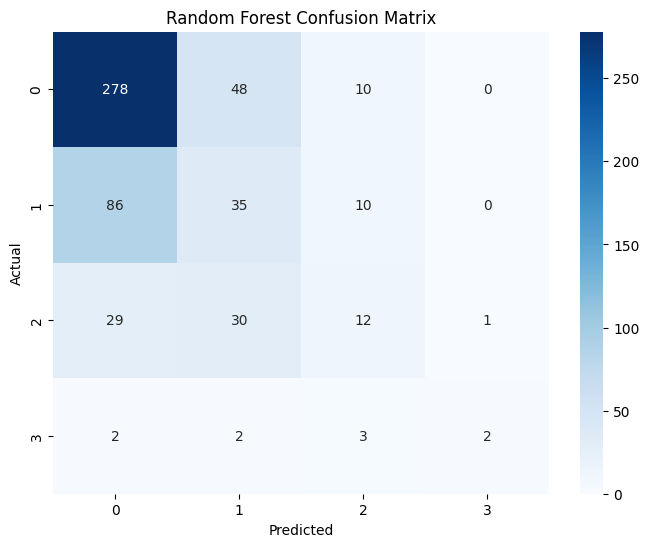

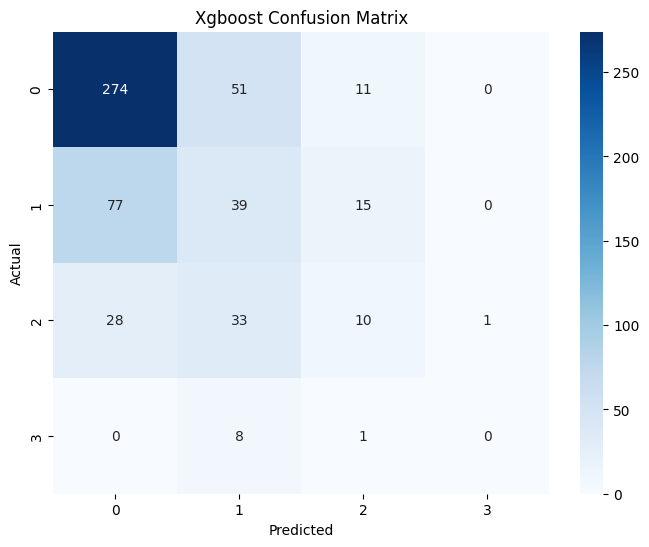

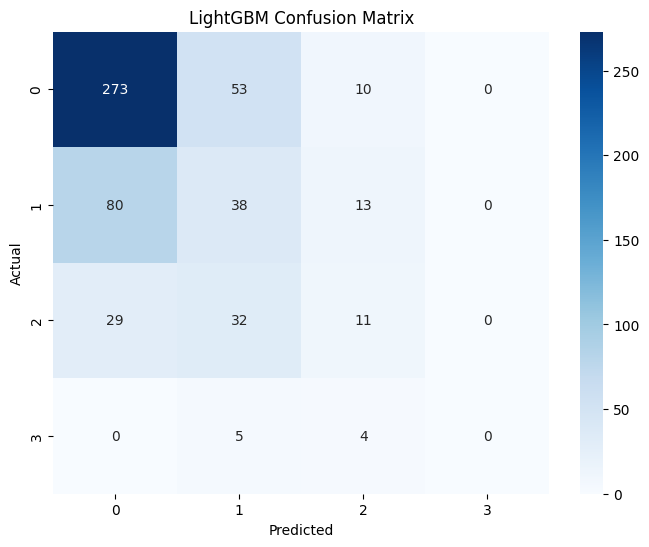

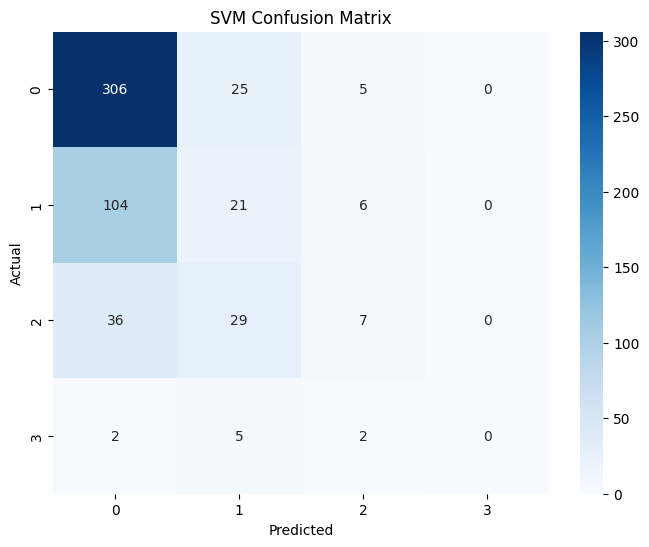

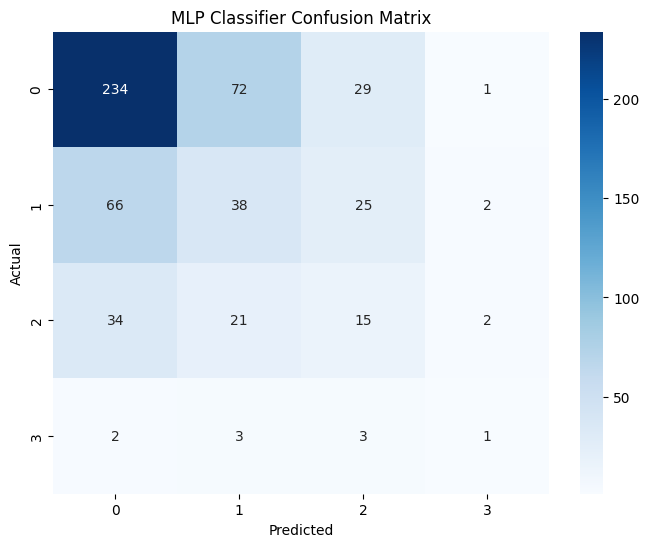

In [45]:
# 繪製混淆矩陣
for model, result in model_results.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(result["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


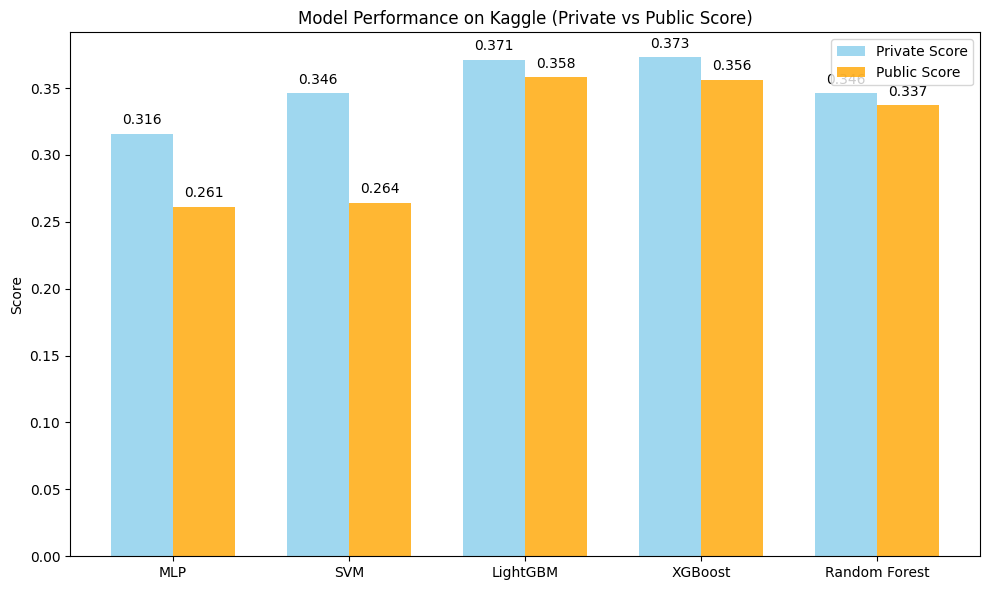

In [46]:
import matplotlib.pyplot as plt

# 模型名稱和對應的分數
models = ["MLP", "SVM", "LightGBM", "XGBoost", "Random Forest"]
private_scores = [0.316, 0.346, 0.371, 0.373, 0.346]
public_scores = [0.261, 0.264, 0.358, 0.356, 0.337]

# 設置圖形大小
plt.figure(figsize=(10, 6))

# 畫出兩種分數的條形圖
bar_width = 0.35
x = range(len(models))
plt.bar(x, private_scores, width=bar_width, label='Private Score', color='skyblue', alpha=0.8)
plt.bar([p + bar_width for p in x], public_scores, width=bar_width, label='Public Score', color='orange', alpha=0.8)

# 添加標籤和標題
plt.xticks([p + bar_width / 2 for p in x], models)
plt.ylabel('Score')
plt.title('Model Performance on Kaggle (Private vs Public Score)')
plt.legend()

# 添加數值標籤
for i, v in enumerate(private_scores):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center', va='bottom')
for i, v in enumerate(public_scores):
    plt.text(i + bar_width, v + 0.005, f"{v:.3f}", ha='center', va='bottom')

# 顯示圖形並保存
plt.tight_layout()
plt.savefig("kaggle_model_performance.png")
plt.show()
